First, a few functions to gather the data from the Nektar output

In [6]:
using DataFrames, Base.Test, Glob, Query

function benchmark_info(filename::String)
    regex = match(r"(gcp|cosma)/(cardiac|naca65)/\2_(\d+)_(\d+)/out", filename)
    platform = Symbol(regex.captures[1])
    bench = Symbol(regex.captures[2])
    nodes = parse(Int64, regex.captures[3])
    ppn = parse(Int64, regex.captures[4])
    platform, bench, nodes, ppn
end

function benchmark_data(filename::String)
    @assert isfile(filename)
    regex = r"Steps: (\d+)\s+Time:\s+(\S*)\s+CPU Time: (\S*)s"
    steps, tstep, time = Int64[], Float64[], Float64[]
    open(filename) do file
        for line in eachline(file)
            capture = match(regex, line)
            capture == nothing && continue
            push!(steps, parse(Int64, capture.captures[1]))
            push!(tstep, parse(Float64, capture.captures[2]))
            push!(time, parse(Float64, capture.captures[3]))
        end
    end
    platform, bench, nnodes, nprocs = benchmark_info(filename)
    DataFrame(:step => steps, :tstep => tstep, :time => time,
              :nodes => nnodes, :ppn => nprocs, :n => nnodes * nprocs,
              :benchmark => bench, :platform => platform)
end

function gather_data(files)
    result = benchmark_data(files[1])
    
    for filename in files[2:end]
       result = [result; benchmark_data(filename)]
    end
    categorical!(result, :benchmark)
    categorical!(result, :platform)
    result
end

@testset "opening file" begin
    filename = "gcp/cardiac/cardiac_1_8/out"
    
    @test benchmark_info(filename)[1] == :gcp
    @test benchmark_info(filename)[2] == :cardiac
    @test benchmark_info(filename)[3] == 1
    @test benchmark_info(filename)[4] == 8
   
    regex = r"Steps: (\d+)\s+Time:\s+(\S*)\s+CPU Time: (\S*)s"
    line = "Steps: 579      Time: 11.58        CPU Time: 11.6915s"
    @test match(regex, line) != nothing
    
    data = benchmark_data(filename)
    @test nrow(data) == 4285
    @test all(data[:nodes] .== 1)
    @test all(data[:ppn] .== 8)
    @test all(data[:benchmark] .== :cardiac)
    @test all(data[1:6, :step] .== 1:6)
    @test all(data[1:6, :tstep] .≈ 0.02 .* collect(1:6))
    @test all(data[1:2, :time] .≈ [7.4155, 1.64536])
end


Test Summary: | Pass  Total
opening file  |   12     12


Base.Test.DefaultTestSet("opening file", Any[], 12, false)

Then we actually gather the data, and compute the speedup vs the code running on Cosma with a single process.

In [15]:
data = gather_data(glob([r"(gcp|cosma)", r"(cardiac|naca65)", r"(cardiac|naca65)_\d+_\d+", "out"]));
means = @from r in data begin
    @where r.step != 1
    @group r by (r.n, r.nodes, r.ppn, r.platform, r.benchmark) into g
    @select {n=g.key[1], nodes=g.key[2],
             ppn=g.key[3], platform=g.key[4],
             benchmark=g.key[5], mean=mean(g..time)}
    @collect DataFrame
end
serial = means[(means[:n] .== 1) .& (means[:platform] .== :cosma), :] 
speedup = @from r in means begin
    @join s in serial on r.benchmark equals s.benchmark
    @select {r.benchmark, r.platform, r.n, r.nodes, r.ppn, r.mean, speedup=s.mean/r.mean}
    @collect DataFrame
end;

We create a plot for each benchmark

In [16]:
using StatPlots, GR
gr()
cardiac = speedup |>
    @filter(_.benchmark == :cardiac && _.ppn < 20) |>
    @map({_.n, _.platform, _.speedup}) |>
    @df StatPlots.scatter(
        :n, :speedup, group=:platform,
        markershape=ifelse.(:platform .== :gcp, :cross, :circle))

title!(cardiac, "Cardiac electro-physiology")
xlabel!(cardiac, "Number of processes")
ylabel!(cardiac, "Speedup vs one process on Cosma");

In [17]:
naca = speedup |>
    @filter(_.benchmark == :naca65 && _.ppn < 20) |>
    @map({_.n, _.platform, _.speedup}) |>
    @df StatPlots.scatter(
        :n, :speedup, group=:platform,
        markershape=ifelse.(:platform .== :gcp, :cross, :circle))
title!(naca, "Wing cross-section")
xlabel!(naca, "Number of processes")
ylabel!(naca, "Speedup vs one process on Cosma");

Then plot and save

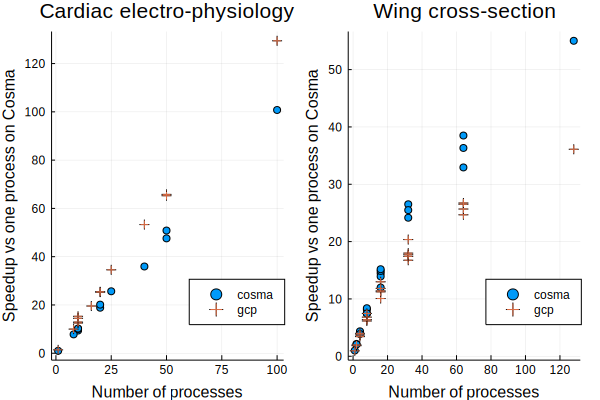

In [18]:
plots = Plots.plot(cardiac, naca, legend=(0.8, 0.2))
Plots.savefig("benchmarks.png")
plots

In [14]:
speedup[speedup[:n] .== 1, :]

,benchmark,platform,n,nodes,ppn,mean,speedup
1,:cardiac,:cosma,1,1,1,16.3453,1.0
2,:naca65,:cosma,1,1,1,0.687331,1.0
3,:cardiac,:gcp,1,1,1,11.647,1.40339
4,:naca65,:gcp,1,1,1,0.724004,0.949347


In [13]:
0.0124915 / 0.0190376

0.6561488843131488